#### Warm Up | Master's Thesis
# VARIATIONAL MONTE CARLO

#### WHAT IS NETKET

The `NetKet` package has specifically developed for Variational Monte Carlo calculations.

NetKet is throughly documented in [its publication](https://scipost.org/SciPostPhysCodeb.7/pdf) and partly in its [online documentation](https://netket.readthedocs.io/en/latest/index.html). When in doubt, check those, and if you find no answer, ask on our official [discussion forum](https://github.com/orgs/netket/discussions).

In [1]:
import netket as nk

import json

import numpy as np
import matplotlib.pyplot as plt
import time

import jax
import jax.numpy as jnp

#### DEFINING THE HAMILTONIAN

The aim of this notebook is to find the Ground State of a transverse field Ising model in 2D. We assume periodic boundary conditions.

$$
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}.
$$

Normally, to write a VMC code you would have to implement yourself a way to compute matrix elements of the operators, as well as code to run a Monte-Carlo sampler, but for sanity and peace of mind in this tutorial we will use NetKet to do it.

`NetKet' requires 3 steps to create a Hamiltonian. First we define the basic structure of the system as a hypergraph. More precisely, a $4 \times 4$ system with periodic boundary conditions. This allows for easy access of vertices and edges of the system.

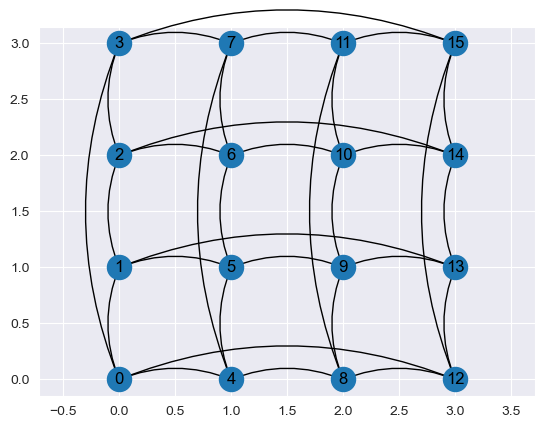

In [2]:
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)
g.draw();

The second step is to define a computational space (or basis) in which we can perform our calculations. We can constrain this combinatorial space by imposing a total magnetization of $0$ allowing only for spin combinations with equal number of up and down spins.

This is somewhat a fundamental object, and you must often declare it. Mainly, it defines how many degrees of freedom you have and how you store configurations. In this case, the hilbert space stores them as a local variable $+1$ or $-1$.

In [3]:
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

Then we must define the Hamiltonian. In `NetKet` you can build individual operators acting on a site.

The functions in `nk.operator.spin` and `nk.operator.boson` are used to create the fundamental operators that can be used to build arbitrary observables and Hamiltonians.

Those functions return an object of type `LocalOperator`, which behaves as some sort of sparse matrix that is optimised to be used in the context of Variational Monte Carlo.

This is extremely similar to the concept of the `MultiQubitMeasurement` I introduced in the QST warm-up. They are restricted to one site only resulting in a very sparse matrix that can be optimized during the VMC.

We do a quick comparison to verify with a 3 site system.

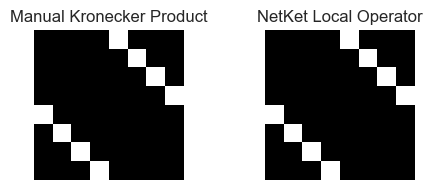

In [4]:
# manual approach using the Kronecker product
sigma_0 = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])
H_kron = np.kron(np.kron(sigma_x, sigma_0), sigma_0)

# multi-step NetKet approach
test_g = nk.graph.Chain(length=3)
test_hi = nk.hilbert.Spin(s=1/2, N=test_g.n_nodes)
test_sx_1 = nk.operator.spin.sigmax(test_hi, 0)
H_nk = test_sx_1.to_dense() # the internal representation is sparse, but we can convert it to dense for comparison


fig, axs = plt.subplots(1, 2, figsize=(5, 2))

axs[0].imshow(H_kron, cmap='gray', interpolation='nearest')
axs[0].set_title("Manual Kronecker Product")
axs[1].imshow(H_nk, cmap='gray', interpolation='nearest')
axs[1].set_title("NetKet Local Operator")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Knowing this, we can construct our hamiltonian by iterating over the sites in our graph:

In [13]:
hamiltonian = nk.operator.LocalOperator(hi)

# the first part of the Hamiltonian just acts on one spin with negative sign
for site in g.nodes():
    hamiltonian -= nk.operator.spin.sigmax(hi, site)

# the second part of the Hamiltonian acts on two spins
for edge in g.edges():
    hamiltonian += nk.operator.spin.sigmaz(hi, edge[0]) @ nk.operator.spin.sigmaz(hi, edge[1])


# we perform a sanity check with the inbuilt Ising operator
hamiltonian_correct = nk.operator.Ising(hi, g, h=1.0, J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5

Most operators in NetKet are implemented in `numba` and they are not compatible with `jax.jit`. However, some particular operator formats are implemented both in `numba`and in a `jax.jit-`compatible format.

First we convert your hamiltonian from the `LocalOperator` format to the `PauliStrings` format by calling `.to_pauli_strings()`, and then we convert the `PauliStrings` operator to the jax format by calling `to_jax_operator()`.

We can even convert it to a sparse matrix from the `jax.experimental.sparse` module.

In [17]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
hamiltonian_jax.to_sparse()

BCSR(float64[65536, 65536], nse=1114112)

#### EXACT DIAGONALIZATION

Up to $N=24$ sites, we can still compute the exact ground state energy using brute-force exact diagonalization. The `scipy` library can calculate the lowest eigenvalue efficiently using a sparse matrix representation.

Note that the standard hamiltonian can be converted to a scipy sparse matrix easily, while the jax-hamiltonian is converted to a jax sparse matrix.



In [24]:
from scipy.sparse.linalg import eigsh

e_gs, psi_gs = eigsh(hamiltonian.to_sparse(), k=1)
e_gs = e_gs[0]
psi_gs = psi_gs.reshape(-1)


# sanity check
assert e_gs.shape == ()
assert psi_gs.shape == (hi.n_states, )
assert -34.01060 < e_gs < -34.01059

#### VARIATIONAL THERMALIZATION

For larger systems the exact diagonalization is not feasible. Instead, we can use a variational Monte Carlo method to find the ground state.

**Mean-Field Ansatz**

In the mean-field ansatz, we approximate the wavefunction as a product of single-spin wavefunctions. Lets say we want to model the outcome when measuring all spins in the $z$-direction. We can write the wavefunction as product of single-spin probabilities:

$$
\langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i),
$$

The single-spin wavefunction gives the probability of measuring spin up or down. They have to sum to one, so we can write them as:

$$
|\Phi(\uparrow)|^2+|\Phi(\downarrow)|^2=1
$$

We want to define the wave-function in polar form, defining it in the complex plane with magnitude and phase:

$$
\Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}
$$

The magnitude encodes some measurement probability (square of the amplitude). Further, we assume that this probability has a sigmoid form depending on the Pauli matrix $\sigma^z$ scaled by a variational parameter $\lambda$. This arises due to the sigmoid function being a continuous approximation of the step function.

$$
P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z))
$$




Since the ground state is real and positive, we set the phase $\phi = 0$. The wave-function $\Phi(\sigma^z)$ in polar form becomes:

$$
\Phi(\sigma^z) = \sqrt{P(\sigma^z)}
$$

Taking the logarithm:

$$
\log \Phi(\sigma^z) = \frac{1}{2} \left( -\log \left( 1 + \exp \left( -\lambda \sigma^z \right) \right) \right)
$$

The factor $\frac{1}{2}$ arises because the wave-function is defined as the square root of the probability $P(\sigma^z)$, and taking the logarithm of the square root introduces this factor. Summing over all spins gives the final log-probability of the entire spin configuration:

$$
\log \Psi_{\mathrm{mf}}(\sigma^z_1, \dots, \sigma^z_N) = \frac{1}{2} \sum_{i=1}^{N} -\log \left( 1 + \exp(-\lambda \sigma_i^z) \right)
$$

In `NetKet` one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).

$$
\langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right]
$$

Here, $\theta$ is a set of parameters or for this case, simply a single parameter $\lambda$.
In this case, the parameter of the model will be just one: $\lambda$.

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku. Some Flax models and layers are already included in `NetKet`.


In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn


# building the model with jax makes its parameters differentiable
class MF(nn.Module):
    @nn.compact
    def __call__(self, x):
        lam = self.param("lambda", nn.initializers.normal(), (1,), float)
        prob = nn.log_sigmoid(lam*x)
        total_prob = 0.5 * jnp.sum(prob, axis=-1)
        return total_prob

In [30]:
# initializing the model with a random seed
model = MF()
key = jax.random.PRNGKey(0)
params = model.init(key, np.random.rand(hi.size))


# perform inference by passing forward 4 samples (16 x 4 tensor)
inputs = hi.random_state(jax.random.key(1), (4,))
log_psi = model.apply(params, inputs)
log_psi

Array([-5.55575789, -5.55575789, -5.54559091, -5.54559091], dtype=float64)

**Calculating State Vectors**

The model will evaluate $\log \psi$ not the wavefunction itself. Furthermore, we would like the model to return a state vector over the entire Hilbert space, which is $2^N$ large.

In [34]:
def to_array(model, params):
    all_configurations = hi.all_states()
    logpsi = model.apply(params, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi


# sanity check
assert to_array(model, params).shape == (hi.n_states, )
assert np.all(to_array(model, params) > 0)
np.testing.assert_allclose(np.linalg.norm(to_array(model, params)), 1.0)

If you implemented everything correctly using `jnp.` operations and not `np.` operations, we might as well be able to jit-compile the function to gain a speed boost!

In [36]:
%timeit to_array(model, params)

8.46 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
# for compilation, we have to specify which arguments to treat as a compile-time constant.
to_array_jit = jax.jit(to_array, static_argnames="model")

# run it once to compile it, before benchmarking
to_array_jit(model, params)

Array([0.0042355 , 0.00419265, 0.00419265, ..., 0.0036364 , 0.0036364 ,
       0.00359962], dtype=float64)

In [39]:
%timeit to_array_jit(model, params)

4.06 ms ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 3.3 Energy
Now, using that function, let's build another one that computes the energy of the mean field state for the given parameters! 
To do that, you can for example convert the hamiltonian to a sparse format and compute the energy

In [26]:
# todo
def compute_energy(model, parameters, hamiltonian):
    psi_gs = to_array(model, parameters)
    ... # todo
    return ...

:::{dropdown} Show solution
```python
def compute_energy(model, parameters, hamiltonian_sparse):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj().T@(hamiltonian_sparse@psi_gs)
```
:::

In [84]:
# if all is good, this should not error
assert compute_energy(model, parameters, hamiltonian.to_sparse()).shape == ()
assert compute_energy(model, parameters, hamiltonian.to_sparse()) < 0

In [85]:
# and like before, we can jit-compile it!
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

Again, to show that jitting is useful, We can time the jitted and non-jitted versions.

In [86]:
%timeit compute_energy(model, parameters, hamiltonian_sparse)
%timeit compute_energy_jit(model, parameters, hamiltonian_jax_sparse)

13.8 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.7 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 3.4 Gradient of the energy

As we used jax so far, we can easily compute the gradient of the energy by simply calling one function: `jax.grad(compute_energy, argnum=1)`, where argnum signals wrt which argument we want to compute the gradient (the 0 is the model, which is not actually an array so we cannot differentiate, the second is the parameters, so that's the one

In [87]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
@partial(jax.jit, static_argnames='model')
def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    return grad_fun(model, parameters, hamiltonian_sparse)

In [88]:
energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
print(gradient)

{'params': {'lambda': Array([-0.40662741], dtype=float64)}}


notice that we now have the same 'structure' as the parameters

### 3.5 Optimise and look for the ground state

Now write a little code to initialise the model, find the groundstate and plot the energy along the optimisation. 

Iterate for 100 iterations, and use `tqdm` to print a beautiful error bar. 

In [ ]:
from tqdm import tqdm

# initialise 
model = MF()
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(iterations)):
    # compute energy and gradient
    #...
    
    # update parameters. Try using a learning rate of 0.01
    # to update the parameters, which are stored as a dictionary (or pytree)
    # you can use jax.tree.map as shown above.
    #...
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy' : energy})

:::{dropdown} Show solution
```python
# initialise 
model = MF()
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(100)):
    # compute energy and gradient
    energy, gradient = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
    
    # update parameters
    parameters = jax.tree.map(lambda x,y:x-0.01*y, parameters, gradient)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy':energy})
```
:::

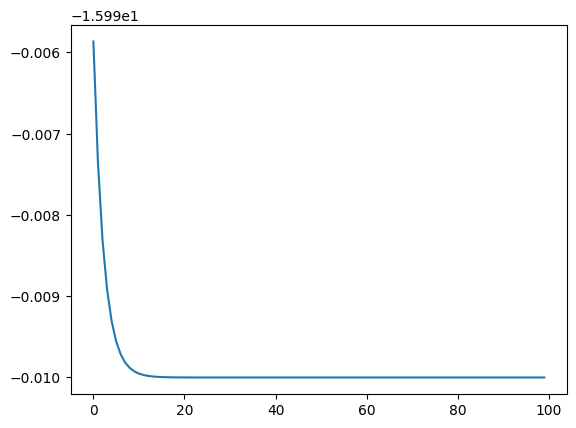

In [94]:
import matplotlib.pyplot as plt

# to plot the data, access it!
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['value'])

But actually a better plot would be the relative error in log-scale, because it allows us to better see what is going on at all scales and compare different runs.

Try to do it yourself!

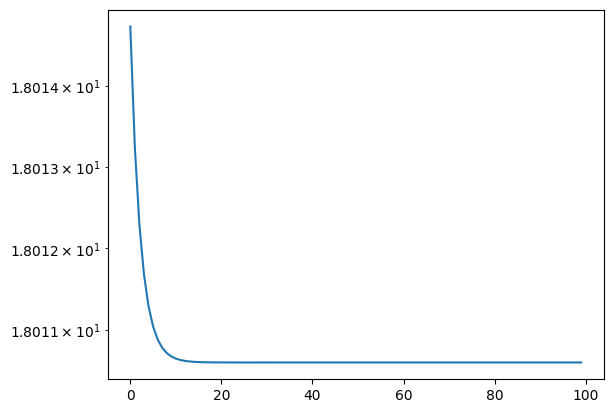

In [99]:
import matplotlib.pyplot as plt

# to plot the data, access it!
plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value']- e_gs))

### 3.6 Jastrow Ansatz

Now try running the same caluclation as above, but by using a Jastrow ansatz instead of a mean Field ansatz. Write it using flax as before.

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp \left( \sum_{ij}\sigma_i J_{ij}\sigma_j\right),$$


In [ ]:
# A Flax model must be a class subclassing `nn.Module`
class Jastrow(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, input_x) function should take as 
    # input a batch of states input_x.shape = (n_samples, N)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, input_x):
        
        n_sites = input_x.shape[-1]
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        # Define the two variational parameters J1 and J2
        J = self.param(
            "J", nn.initializers.normal(), (n_sites,n_sites), float
        )
        # ensure same data types
        dtype = jax.numpy.promote_types(J.dtype, input_x.dtype)
        J = J.astype(dtype)
        input_x = input_x.astype(dtype)
        
        # note that J_ij is not symmetric. So we symmetrize it by hand
        J_symm = J.T + J
        
        # TODO compute the result 
        res = # use vectorised operations. Make sure they work with arbitrary shapes of dimensions.
        # look into jnp.einsum.

        return res

:::{dropdown} Show solution
```python
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]
        J = self.param(
            "J", nn.initializers.normal(), (n_sites,n_sites), float
        )
        J_symm = J.T + J
        return jnp.einsum("...i,ij,...j", x, J_symm, x)
```
:::

In [103]:
# if the code above is correct, this should run
model_jastrow = Jastrow()

one_sample = hi.random_state(jax.random.key(0))
batch_samples = hi.random_state(jax.random.key(0), (5,))
multibatch_samples = hi.random_state(jax.random.key(0), (5,4,))

parameters_jastrow = model_jastrow.init(jax.random.key(0), one_sample)
assert parameters_jastrow['params']['J'].shape == (hi.size, hi.size)
assert model_jastrow.apply(parameters_jastrow, one_sample).shape == ()
assert model_jastrow.apply(parameters_jastrow, batch_samples).shape == batch_samples.shape[:-1]
assert model_jastrow.apply(parameters_jastrow, multibatch_samples).shape == multibatch_samples.shape[:-1]

**And now rerun the same analysis as before but with this ansatz*

## 4. Monte Carlo complications 

Until now we did everything by summing over the whole hilbert space, but for larger problems that won't be possible. So let's look into MC sampling.

### 4.1 Generating samples

For this tutorial, we won't look into the nitty gritty details of sampling, but instead rely on a set of samplers already written for us. Let's consider a simple MCMC sampler that propose new states by flipping individual spins

In [104]:
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)

And the samplers are used as follows:
 - First you initialise the 'sampler state' that contains the mutable state and rng of the sampler
 - Every time you change the parameters you reset it
 - to generate new samples you call .sample_chain.

In [105]:
sampler_state = sampler.init_state(model, parameters, seed=1)
sampler_state = sampler.reset(model, parameters, sampler_state)
samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=100)

print(samples.shape)
# those are the three dimensions: 20 chains, 100 length per chain and 16 spins per sample.
# Note: chains are sometimes refereed to as walkers
# Note: the chain length is actually the length of the returned samples. In reality, the sampler generates 
# chains of length `chain_length * sampler.sweep_size` and returns you 1 sample every   sampler.sweep_size

(20, 100, 16)


To generate more samples, simply call `sampler.sample` again or with a different `chain_length`.
If you change the parameters, you should call `sampler.reset`.

### 4.2 Computing the Energy

We want to compute the energy as an expectation value, therefore as

$$
   E = \sum_i^{N_s} \frac{E_\text{loc}(\sigma_i)}{N_s}
$$

where $\sigma_i$ are the samples and Eloc is

$$
  E_\text{loc}(\sigma) = \frac{\langle \sigma |H|\psi\rangle}{\langle \sigma |\psi\rangle} = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)}
$$

but the sum in principle is over exponentially many entries. Instead we can do the following

$$
  E_\text{loc}(\sigma) = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)} = \sum_{\eta\,\, \text{s.t.} \,\,\langle\sigma|H|\eta\rangle \neq 0} \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)} 
$$


Those entries can be extracted through our 'special' operators. 

In [106]:
# given sigma
sigma = hi.random_state(jax.random.key(1))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

In [107]:
# so for 1 sample sigma
print(sigma.shape)

# we have 17 connected samples eta, each composed by 16 spins
print(eta.shape)
# and 17 matrix elements
print(H_sigmaeta.shape)

(16,)
(17, 16)
(17,)


This also applies for batches of configurations

In [108]:
# given sigma
sigma = hi.random_state(jax.random.key(1), (4,5))

eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)

# so for each of the (4,5) samples sigma each of 16 spins
print(sigma.shape)

# we have 17 connected samples eta, each composed by 16 spins, in a tensor of shape (4,5,17,16)
print(eta.shape)
# and 17 matrix elements
print(H_sigmaeta.shape)

(4, 5, 16)
(4, 5, 17, 16)
(4, 5, 17)


_TODO_: Now use this `get_conn_padded` to write a function that computes the local energy given a model and a set parameters

$$
  E_\text{loc}(\sigma) = \sum_\eta \langle\sigma|H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)} = \sum_{\eta\,\, \text{s.t.} \,\,\langle\sigma|H|\eta\rangle \neq 0} \langle\sigma|H|\eta\rangle \exp[\log\psi(\eta) - \log\psi(\sigma)] 
$$


In [109]:
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)
    
    logpsi_sigma = ...
    logpsi_eta = ...
    
    # to match their dimensions and broadcast, jnp.expand_dims(logpsi_sigma, -1) might help
    ...
    
    return res

:::{dropdown} Show solution
```python
# todelete
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)
    
    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
    return res
```
:::

In [112]:
# if you wrote it correctly, you should get to work the following tests
assert compute_local_energies(model, parameters, hamiltonian_jax, samples[0]).shape == samples.shape[1:-1]
assert compute_local_energies(model, parameters, hamiltonian_jax, samples).shape == samples.shape[:-1]

In [113]:
# and if you did not do crazy things, this should also jit compile
jax.jit(compute_local_energies, static_argnames='model')(model, parameters, hamiltonian_jax, sigma)

Array([[-20., -16., -12., -20., -12.],
       [-16., -12., -16., -16., -12.],
       [-16., -16., -12., -20., -24.],
       [-16., -20., -24., -16., -12.]], dtype=float64)

### 4.3 Sampling the energy

So now write a function that computes the energy and estimates its error. I remind you that the error is given by 

$$
    \epsilon_E = \sqrt{\frac{\mathbb{V}\text{ar}(E_\text{loc})}{N_\text{samples}}}
$$

In [114]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    E_average = ...
    E_variance = ...
    E_error = ...
    
    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

:::{dropdown} Show solution
```python
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)
    
    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)
```
:::

In [120]:
# this should run correctly
isinstance(estimate_energy(model, parameters, hamiltonian_jax, samples), nk.stats.Stats)
print(estimate_energy(model, parameters, hamiltonian_jax, samples))

-16.00 ± 0.13 [σ²=31.31]


we can also check that by increasing the number of samples, we get a good prediction within the standard error of the 'full summation' calculations

In [121]:
samples_many, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=5000)

print("exact: ", compute_energy(model, parameters, hamiltonian_jax))
print("Estimate: ", estimate_energy(model, parameters, hamiltonian_jax, samples_many))


exact:  -15.999999999999408
Estimate:  -15.979 ± 0.018 [σ²=31.965]


### 4.4 Sampling the gradient of the energy 

We have seen during the class that the gradient of the energy can be estimated according to the formula

$$
    \nabla_k E = \mathbb{E}_{\sigma\sim|\psi(\sigma)|^2} \left[ (\nabla_k \log\psi(\sigma))^\star \left( E_\text{loc}(\sigma) - \langle E \rangle\right)\right] \approx \frac{1}{N_s}\sum_i^{N_s} (\nabla_k \log\psi(\sigma_i))^\star \left( E_\text{loc}(\sigma_i) - \langle E \rangle\right)
$$

Where $\langle E \rangle$ can be estimated as $\langle E \rangle \approx \frac{1}{N_s}\sum_i E_\text{loc}(\sigma_i)$

Now, for a second, think of $\nabla_k \log\psi(\sigma_i)$ as the _JACOBIAN_ of the function $\log\psi_\sigma : \mathbb{R}^{N_\text{pars}} \rightarrow \mathbb{R}^{N_\text{samples}}$, and think for a moment of $E_\text{loc}(\sigma_i)$ as a vector of size $\mathbb{R}^{N_\text{samples}}$

In [123]:
# reshape samples in a vector of size (N_pars x N)
sigma_vector = samples.reshape(-1, hi.size)

# lets see that function logpsi_sigma
logpsi_sigma_fun = lambda pars : model_jastrow.apply(parameters_jastrow, sigma_vector)

# input to the function are only the parameters, output is a vector of size n samples
print("N_samples is equal to: ", logpsi_sigma_fun(parameters_jastrow).shape)

N_samples is equal to:  (2000,)


So we can compute the jacobian of this function!

In [124]:
jacobian = jax.jacrev(logpsi_sigma_fun)(parameters_jastrow)

#
print("The parameters of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, parameters_jastrow))

print("The jacobian of jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, jacobian))

The parameters of jastrow have shape:
 {'params': {'J': (16, 16)}}
The jacobian of jastrow have shape:
 {'params': {'J': (2000, 16, 16)}}


Now implement a function that computes the jacobian-vector product in order to estimate the gradient of the energy. You can either do this vector-Jacobian-transpose product manually by using `jax.jacrev` and `jax.tree.map`, but you can also have a look at `jax.vjp` which does it automatically for you.

In [ ]:
## TODO

# @partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])
    
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model_jastrow.apply(parameters_jastrow, sigma_vector)
    ...
    # use jacrev with jax.tree.map, or even better, jax.vjp
    E_grad = ...
    
    # compute the energy as well
    E_average = ...
    E_variance = ...
    E_error = ...
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)
    
    return E, E_grad

:::{dropdown} Show solution
```python
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])
    
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model.apply(pars, sigma)

    # use jacrev with jax.tree.map, or even better, jax.vjp
    _, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
    E_grad = vjpfun((E_loc - E_average)/E_loc.size)

    return E, E_grad[0]
```
:::

If you are a fast person, Try to implement this function both usin `jax.jacrev` and `jax.vjp` and try to see which one is faster. You might need to benchmark it for different Neural Networks...

### 4.5: Let's get down to business

Now let's wrap everything up and let's use this code to compute the ground state with an SGD optimisation using the mean field and jastrow ansatz

In [128]:
from tqdm import tqdm

# settings 
model = MF()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)
    
    # update parameters. Try using a learning rate of 0.01
    # ... implement it!
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy' : E})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 129.40it/s]


:::{dropdown} Show solution
```python
from tqdm import tqdm

# settings 
model = Jastrow()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)
    
    # update parameters. Try using a learning rate of 0.01
    parameters = jax.tree.map(lambda x,y: x-0.005*y, parameters, E_grad)
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy':E})
```
:::

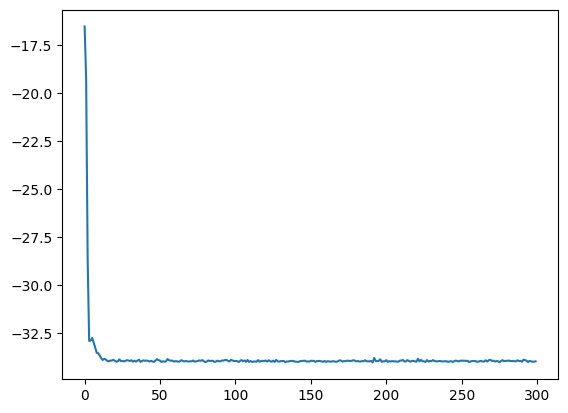

In [132]:
# to plot the data, access it!
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])

## 5 : Future things to try

### 5.1 : Try to implement a FeedForward network

Try to use flax to implement a simple Feed Forward Neural Network with 1 or 2 layers and becnhmark it. Look at the documentation and try using some `nn.Dense` layers together with some activation functions of your choice. Try going for something like a 2 layers Dense with `relu` activation function and a final pooling operation.

### 5.2: Try better optimisers

There is a library, [optax](https://optax.readthedocs.io/en/latest/), that implements several optimisers. 
Try to use adam or other optimisers.
The way you use them is as follows:

In [ ]:
import optax

# define
optimizer = optax.adam(learning_rate=0.01)

# initialise
parameters = model.init(...)
optimizer_state = optimizer.init(parameters)

for i in range(n_iters):
    E, E_grad = estimate_energy_and_grad(..., parameters, ...)
    
    updates, optimizer_state = optimizer.update(E_grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)


### 5.3: Sky's the limit

What you've seen so far gives you the tools to quickly get started in running VMC calculations, without having to worry about sampling (which is a bit tricky to implement) and operators (which are very tricky to implement).

You can use this as a starting point to implement stochastic reconfiguration, the dynamics, and much more!